# 准备工作

安装scikit-learn包，这里scikit-learn是用于划分训练集和验证集

In [1]:
# !pip install scikit-learn

In [2]:
import pandas as pd
import torch
import os
import numpy as np
import time
import matplotlib.pyplot as plt
import torchvision
from torch import nn
from PIL import Image
from torch.nn import functional as F
from torch.utils import data
from torchvision import transforms
from torchvision.io import read_image
from torch.utils.data import Dataset
from torch.optim import lr_scheduler
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# 获取数据集

数据集使用的是大佬李沐在kaggle上组织的[Classify Leaves](https://www.kaggle.com/competitions/classify-leaves?rvi=1)比赛。  
训练模型来预测植物物种，该任务是预测叶子图像的类别。该数据集包含176个类别，18353张训练图像，8800张测试图像。每个类别至少有 50 张图像用于训练。测试集平均分为公共排行榜和私人排行榜。

数据集下载地址：https://www.kaggle.com/competitions/29193/download-all

# 数据集概述

解压后数据集的目录结构如下  
* images：图像  
* sample_submission.csv：提交预测结果的示例文件  
* test.csv：测试集image的文件  
* train.csv：训练集image、labe的文件

> └─images  
> └─sample_submission.csv  
> └─test.csv  
> └─train.csv

# 预览数据集

定义图像和标签的路径

In [3]:
train_path = '/kaggle/input/d2lclassifyleaves/train.csv'
img_dir = '/kaggle/input/d2lclassifyleaves'

预览train.csv

In [4]:
train_csv = pd.read_csv(train_path)
train_csv.head()

,image,label
0,images/0.jpg,maclura_pomifera
1,images/1.jpg,maclura_pomifera
2,images/2.jpg,maclura_pomifera
3,images/3.jpg,maclura_pomifera
4,images/4.jpg,maclura_pomifera


In [5]:
len(train_csv)

18353

* train.csv中的label是文字描述，需要将label转换成数字，同时训练后的分类要转换为文字才能提交  
* 总共有18353个训练样本，需要划分训练集和验证集

预览前8张图像，果然都是叶子

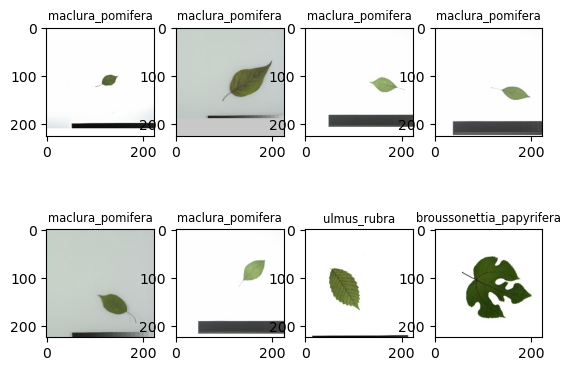

In [6]:
for i in range(8):
    image = Image.open(os.path.join(img_dir, train_csv.iloc[i, 0]))
    plt.subplot(2, 4, i+1)
    plt.imshow(image)
    plt.title(train_csv.iloc[i, 1], fontsize='small')

图像大小为：224*224

In [7]:
image = Image.open(os.path.join(img_dir, train_csv.iloc[0, 0]))
image.size

(224, 224)

# 生成label和cls的映射

In [8]:
labels = sorted(list(set(train_csv['label'])))
len_labels = len(labels)
labels_cls_map = dict(zip(labels, range(len_labels)))
cls_labels_map = {v : k for k, v in labels_cls_map.items()}

# 定义训练使用到的工具方法

定义获取dataloader的使用进程数的方法

In [9]:
def get_dataloader_workers():
    """使用2个进程来读取数据"""
    return 2

定义获取gpu设备的方法

In [10]:
def try_gpu(i=0):  #@save
    """如果存在，则返回gpu(i)，否则返回cpu()"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

# 自定义类Dataset

* 训练Dataset: LeavesImageDataset  
* 测试Dataset: LeavesImageTestDataset

In [11]:
class LeavesImageDataset(Dataset):
    def __init__(self, X, y, root_dir: str, transform=None):
        self.X = X
        self.y = y
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self) -> int:
        return len(self.y)

    def __getitem__(self, idx: int):
        img_path = os.path.join(self.root_dir, self.X[idx])
        image = Image.open(img_path)
        label = labels_cls_map[self.y[idx]]
        if self.transform:
            image = self.transform(image)
        return image, label

class LeavesImageTestDataset(Dataset):
    def __init__(self, annotations_file: str, root_dir: str, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self) -> int:
        return len(self.img_labels)

    def __getitem__(self, idx: int):
        img_path = os.path.join(self.root_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image

# 定义网络

使用torchVison.models现成的ResNet50模型,并初始化预训练模型

In [12]:
def get_net(nums_cls, train = True):
    if train:
#         net = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)
        net = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V2)
    else:
        net = torchvision.models.resnet50()
    in_features = net.fc.in_features
    net.fc = nn.Linear(in_features, nums_cls)
    return net

# 定义训练方法

In [13]:
def train_model(net, dataset_sizes, dataloaders, num_epochs, lr, device, weight_decay):
    print('training on', device)
    print('train_nums: ', dataset_sizes['train'])
    print('val_nums: ', dataset_sizes['val'])
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr,  momentum=0.9, weight_decay = weight_decay)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    loss = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()
            else:
                net.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            start_time = time.time()
            for X, y in tqdm(dataloaders[phase]):
                optimizer.zero_grad()
                X, y = X.to(device), y.to(device)
                with torch.set_grad_enabled(phase == 'train'):
                    y_hat = net(X)
                    _, preds = torch.max(y_hat, 1)
                    l = loss(y_hat, y)
                    
                    if phase == 'train':        
                        l.backward()
                        optimizer.step()
                        
                running_loss += l.item() * X.size(0)
                running_corrects += torch.sum(preds == y.data)
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            elapsed_time = time.time() - start_time
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} elapsed time: {elapsed_time:.2f}秒', end='\n')
        #每5轮保存一次模型
        if epoch % 5 == 0 or epoch == (num_epochs-1):
            torch.save(net.state_dict(), "resnet_50_"+ str(epoch) +".pth")
        print()
    return net

# 划分训练集和验证集

In [14]:
X = train_csv.iloc[:, 0]
Y = train_csv.iloc[:, 1]
X_train, X_val, Y_train, Y_val = train_test_split(X.values, Y.values, test_size=0.25, random_state=123)

# 定义训练数据

In [15]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_set = {
    'train': LeavesImageDataset(X_train, Y_train, img_dir, data_transforms['train']),
    'val': LeavesImageDataset(X_val, Y_val, img_dir, data_transforms['val'])
}
dataset_sizes = {
    'train': len(data_set['train']),
    'val': len(data_set['val'])
}

# 训练

In [16]:
lr, num_epochs, batch_size,weight_decay = 0.01, 30, 64, 1e-3
dataloaders = {
    'train': data.DataLoader(dataset=data_set['train'], batch_size=batch_size, shuffle=True, num_workers=get_dataloader_workers(), pin_memory=True),
    'val': data.DataLoader(dataset=data_set['val'], batch_size=batch_size, shuffle=False, num_workers=get_dataloader_workers(), pin_memory=False)
}
model = train_model(get_net(len(labels_cls_map)), dataset_sizes, dataloaders, num_epochs, lr, try_gpu(), weight_decay)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 94.3MB/s]


training on cuda:0
train_nums:  13764
val_nums:  4589
Epoch 0/29
----------


100%|██████████| 216/216 [01:37<00:00,  2.21it/s]


train Loss: 3.4083 Acc: 0.2592 elapsed time: 97.79秒


100%|██████████| 72/72 [00:28<00:00,  2.50it/s]


val Loss: 1.4974 Acc: 0.5668 elapsed time: 28.84秒

Epoch 1/29
----------


100%|██████████| 216/216 [01:07<00:00,  3.20it/s]


train Loss: 1.3871 Acc: 0.6143 elapsed time: 67.47秒


100%|██████████| 72/72 [00:14<00:00,  4.96it/s]


val Loss: 0.8642 Acc: 0.7418 elapsed time: 14.52秒

Epoch 2/29
----------


100%|██████████| 216/216 [01:07<00:00,  3.20it/s]


train Loss: 1.0095 Acc: 0.7210 elapsed time: 67.61秒


100%|██████████| 72/72 [00:15<00:00,  4.71it/s]


val Loss: 0.5761 Acc: 0.8095 elapsed time: 15.31秒

Epoch 3/29
----------


100%|██████████| 216/216 [01:07<00:00,  3.20it/s]


train Loss: 0.8434 Acc: 0.7714 elapsed time: 67.43秒


100%|██████████| 72/72 [00:14<00:00,  4.96it/s]


val Loss: 0.4712 Acc: 0.8494 elapsed time: 14.52秒

Epoch 4/29
----------


100%|██████████| 216/216 [01:07<00:00,  3.18it/s]


train Loss: 0.7352 Acc: 0.7989 elapsed time: 67.95秒


100%|██████████| 72/72 [00:15<00:00,  4.64it/s]


val Loss: 0.4575 Acc: 0.8501 elapsed time: 15.54秒

Epoch 5/29
----------


100%|██████████| 216/216 [01:07<00:00,  3.20it/s]


train Loss: 0.6729 Acc: 0.8137 elapsed time: 67.49秒


100%|██████████| 72/72 [00:15<00:00,  4.70it/s]


val Loss: 0.4920 Acc: 0.8451 elapsed time: 15.34秒

Epoch 6/29
----------


100%|██████████| 216/216 [01:07<00:00,  3.20it/s]


train Loss: 0.6196 Acc: 0.8288 elapsed time: 67.56秒


100%|██████████| 72/72 [00:14<00:00,  4.86it/s]


val Loss: 0.4103 Acc: 0.8677 elapsed time: 14.84秒

Epoch 7/29
----------


100%|██████████| 216/216 [01:07<00:00,  3.20it/s]


train Loss: 0.4645 Acc: 0.8785 elapsed time: 67.53秒


100%|██████████| 72/72 [00:15<00:00,  4.75it/s]


val Loss: 0.1758 Acc: 0.9416 elapsed time: 15.18秒

Epoch 8/29
----------


100%|██████████| 216/216 [01:07<00:00,  3.19it/s]


train Loss: 0.4204 Acc: 0.8916 elapsed time: 67.77秒


100%|██████████| 72/72 [00:14<00:00,  4.96it/s]


val Loss: 0.1599 Acc: 0.9475 elapsed time: 14.53秒

Epoch 9/29
----------


100%|██████████| 216/216 [01:08<00:00,  3.17it/s]


train Loss: 0.3905 Acc: 0.8989 elapsed time: 68.21秒


100%|██████████| 72/72 [00:15<00:00,  4.59it/s]


val Loss: 0.1603 Acc: 0.9475 elapsed time: 15.69秒

Epoch 10/29
----------


100%|██████████| 216/216 [01:07<00:00,  3.19it/s]


train Loss: 0.3690 Acc: 0.9082 elapsed time: 67.65秒


100%|██████████| 72/72 [00:16<00:00,  4.48it/s]


val Loss: 0.1542 Acc: 0.9473 elapsed time: 16.10秒

Epoch 11/29
----------


100%|██████████| 216/216 [01:07<00:00,  3.21it/s]


train Loss: 0.3608 Acc: 0.9069 elapsed time: 67.38秒


100%|██████████| 72/72 [00:14<00:00,  5.03it/s]


val Loss: 0.1526 Acc: 0.9488 elapsed time: 14.34秒

Epoch 12/29
----------


100%|██████████| 216/216 [01:07<00:00,  3.18it/s]


train Loss: 0.3708 Acc: 0.9058 elapsed time: 67.88秒


100%|██████████| 72/72 [00:15<00:00,  4.62it/s]


val Loss: 0.1450 Acc: 0.9527 elapsed time: 15.60秒

Epoch 13/29
----------


100%|██████████| 216/216 [01:07<00:00,  3.19it/s]


train Loss: 0.3457 Acc: 0.9122 elapsed time: 67.65秒


100%|██████████| 72/72 [00:16<00:00,  4.45it/s]


val Loss: 0.1433 Acc: 0.9508 elapsed time: 16.18秒

Epoch 14/29
----------


100%|██████████| 216/216 [01:07<00:00,  3.20it/s]


train Loss: 0.3642 Acc: 0.9078 elapsed time: 67.54秒


100%|██████████| 72/72 [00:15<00:00,  4.66it/s]


val Loss: 0.1425 Acc: 0.9518 elapsed time: 15.46秒

Epoch 15/29
----------


100%|██████████| 216/216 [01:07<00:00,  3.19it/s]


train Loss: 0.3505 Acc: 0.9141 elapsed time: 67.79秒


100%|██████████| 72/72 [00:15<00:00,  4.70it/s]


val Loss: 0.1388 Acc: 0.9527 elapsed time: 15.33秒

Epoch 16/29
----------


100%|██████████| 216/216 [01:07<00:00,  3.19it/s]


train Loss: 0.3443 Acc: 0.9123 elapsed time: 67.79秒


100%|██████████| 72/72 [00:16<00:00,  4.45it/s]


val Loss: 0.1383 Acc: 0.9560 elapsed time: 16.21秒

Epoch 17/29
----------


100%|██████████| 216/216 [01:07<00:00,  3.19it/s]


train Loss: 0.3608 Acc: 0.9082 elapsed time: 67.65秒


100%|██████████| 72/72 [00:15<00:00,  4.59it/s]


val Loss: 0.1390 Acc: 0.9538 elapsed time: 15.70秒

Epoch 18/29
----------


100%|██████████| 216/216 [01:07<00:00,  3.19it/s]


train Loss: 0.3327 Acc: 0.9143 elapsed time: 67.75秒


100%|██████████| 72/72 [00:16<00:00,  4.33it/s]


val Loss: 0.1399 Acc: 0.9542 elapsed time: 16.65秒

Epoch 19/29
----------


100%|██████████| 216/216 [01:07<00:00,  3.19it/s]


train Loss: 0.3553 Acc: 0.9090 elapsed time: 67.77秒


100%|██████████| 72/72 [00:16<00:00,  4.48it/s]


val Loss: 0.1350 Acc: 0.9560 elapsed time: 16.07秒

Epoch 20/29
----------


100%|██████████| 216/216 [01:07<00:00,  3.19it/s]


train Loss: 0.3408 Acc: 0.9164 elapsed time: 67.68秒


100%|██████████| 72/72 [00:14<00:00,  4.92it/s]


val Loss: 0.1359 Acc: 0.9553 elapsed time: 14.66秒

Epoch 21/29
----------


100%|██████████| 216/216 [01:07<00:00,  3.19it/s]


train Loss: 0.3336 Acc: 0.9151 elapsed time: 67.69秒


100%|██████████| 72/72 [00:16<00:00,  4.46it/s]


val Loss: 0.1381 Acc: 0.9536 elapsed time: 16.14秒

Epoch 22/29
----------


100%|██████████| 216/216 [01:07<00:00,  3.19it/s]


train Loss: 0.3530 Acc: 0.9106 elapsed time: 67.75秒


100%|██████████| 72/72 [00:15<00:00,  4.53it/s]


val Loss: 0.1348 Acc: 0.9542 elapsed time: 15.91秒

Epoch 23/29
----------


100%|██████████| 216/216 [01:07<00:00,  3.20it/s]


train Loss: 0.3453 Acc: 0.9150 elapsed time: 67.56秒


100%|██████████| 72/72 [00:16<00:00,  4.25it/s]


val Loss: 0.1366 Acc: 0.9553 elapsed time: 16.94秒

Epoch 24/29
----------


100%|██████████| 216/216 [01:07<00:00,  3.19it/s]


train Loss: 0.3648 Acc: 0.9075 elapsed time: 67.64秒


100%|██████████| 72/72 [00:16<00:00,  4.38it/s]


val Loss: 0.1413 Acc: 0.9523 elapsed time: 16.45秒

Epoch 25/29
----------


100%|██████████| 216/216 [01:07<00:00,  3.19it/s]


train Loss: 0.3503 Acc: 0.9095 elapsed time: 67.73秒


100%|██████████| 72/72 [00:15<00:00,  4.73it/s]


val Loss: 0.1375 Acc: 0.9549 elapsed time: 15.23秒

Epoch 26/29
----------


100%|██████████| 216/216 [01:08<00:00,  3.17it/s]


train Loss: 0.3342 Acc: 0.9175 elapsed time: 68.22秒


100%|██████████| 72/72 [00:16<00:00,  4.50it/s]


val Loss: 0.1334 Acc: 0.9566 elapsed time: 16.01秒

Epoch 27/29
----------


100%|██████████| 216/216 [01:07<00:00,  3.19it/s]


train Loss: 0.3391 Acc: 0.9140 elapsed time: 67.65秒


100%|██████████| 72/72 [00:15<00:00,  4.68it/s]


val Loss: 0.1344 Acc: 0.9551 elapsed time: 15.39秒

Epoch 28/29
----------


100%|██████████| 216/216 [01:07<00:00,  3.20it/s]


train Loss: 0.3414 Acc: 0.9146 elapsed time: 67.56秒


100%|██████████| 72/72 [00:15<00:00,  4.65it/s]


val Loss: 0.1353 Acc: 0.9547 elapsed time: 15.50秒

Epoch 29/29
----------


100%|██████████| 216/216 [01:07<00:00,  3.19it/s]


train Loss: 0.3656 Acc: 0.9087 elapsed time: 67.71秒


100%|██████████| 72/72 [00:15<00:00,  4.58it/s]


val Loss: 0.1354 Acc: 0.9584 elapsed time: 15.72秒



# 定义评估方法

In [17]:
def val(model, device):
    test_dataloader = dataloaders['train']
    corrects = 0
    total = len(data_set['train'])
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(test_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            outputs = F.softmax(outputs, 1)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
    print("Test Acc: {:.4f}".format(corrects.double() / total))

# 定义预测方法

In [18]:
def pred(net, test_path, img_dir, batch_size, device, output):
    predict = torch.tensor([]).to(device)
    sub_dataset = LeavesImageTestDataset(test_path, img_dir, data_transforms['val'])
    sub_iter= data.DataLoader(dataset=sub_dataset, batch_size=batch_size,
                              shuffle=False, num_workers=get_dataloader_workers(), pin_memory=False)
    net.eval()
    net = net.to(device)
    for X in tqdm(sub_iter):
        with torch.no_grad():
            X = X.to(device)
            y_hat = net(X)
            y_hat = F.softmax(y_hat, 1)
            values, preds = torch.max(y_hat, 1)
            predict = torch.cat((predict, preds), dim=0)
    predict = predict.detach().cpu().numpy()
    predict_label = []
    for i in range(predict.shape[0]):
        predict_label.append(cls_labels_map[int(predict[i])])
    submission = pd.read_csv(test_path)
    submission['label'] = pd.Series(predict_label)
    sub_path = os.path.join(output, 'submission.csv')
    submission.to_csv(sub_path, index = False)

# 评估模型

In [21]:
net = get_net(len_labels, train = False)
state_dict = torch.load('/kaggle/working/resnet_50_20.pth')
net.load_state_dict(state_dict)
val(net, try_gpu())

100%|██████████| 216/216 [00:37<00:00,  5.70it/s]

Test Acc: 0.9206


# 预测

加载test.csv,预测并生成提交文件

In [22]:
test_path = '/kaggle/input/d2lclassifyleaves/test.csv'
out_path = '/kaggle/working/'
pred(net, test_path, img_dir, batch_size, try_gpu(), out_path)

100%|██████████| 138/138 [00:25<00:00,  5.51it/s]
